In [16]:
from scipy.spatial.distance import squareform, cdist
from scipy.spatial.distance import pdist
from scipy.integrate import quad
from itertools import combinations, product, combinations_with_replacement
from functools import partial

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import scipy
import graco
import os

In [4]:
DATA_DIRECTORY = "/media/clusterduck123/joe/data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/yeast"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance-matrices"

# Density calculation

In [57]:
@np.vectorize
def f_Z(t):
    return np.where(0<t<1, 1/np.sqrt(t)-1, 0)

@np.vectorize
def f_Z2(t):
    return quad(lambda tau:f_Z(t-tau)*f_Z(tau),0,2)[0]

def kernel(t, tau):
    return (1/np.sqrt(t-tau)-1)*(1/np.sqrt(tau)-1)

@np.vectorize
def f_ZZ2(t):
    return quad(lambda tau : kernel(t,tau), max(0,t-1), min(1,t))[0]

@np.vectorize
def f_Z3(t):
    return quad(lambda tau:f_ZZ2(t-tau)*f_Z(tau),0,3)[0]

In [58]:
X1 = np.random.uniform(size = 5000)
Y1 = np.random.uniform(size = 5000)

X2 = np.random.uniform(size = 5000)
Y2 = np.random.uniform(size = 5000)

X3 = np.random.uniform(size = 5000)
Y3 = np.random.uniform(size = 5000)

Z1 = np.abs(X1-Y1)**2
Z2 = np.abs(X2-Y2)**2
Z3 = np.abs(X2-Y2)**2

Z = Z1+Z2+Z3

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improv

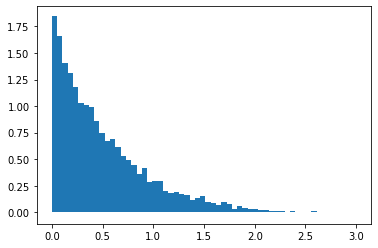

In [59]:
x = np.linspace(0,3,200)
y = f_Z3(x)

plt.hist(Z, bins=50, density=True);
plt.plot(x,y)

# Nan-control

In [4]:
feature = 'GDV'

MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

all_distances = sorted('_'.join(filename.split('_')[:-1]) 
                           for filename in os.listdir(f"{MATRIX_DIRECTORY}/{feature}"))

In [5]:
for distance in all_distances:
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/{feature}/{distance}_BioGRID.txt", delimiter=' ')
    print(distance, df.isna().any().any())

GDV_similarity False
braycurtis False
canberra False
chebyshev False
cityblock False
correlation False
cosine False
euclidean False
mahalanobis False
normalized1_l1 False
normalized1_l2 False
normalized1_linf False
normalized2_l1 False
normalized2_l2 False
normalized2_linf False
seuclidean False
sqeuclidean False


# Matrix preparation

In [228]:
G = nx.erdos_renyi_graph(100,0.1)
GDV = graco.orbits(G)
deg = GDV['0'].values

A = nx.to_numpy_array(G)
Asq = A@A
T = Asq*A

E = Asq-T
np.fill_diagonal(E,0)


B1 = A*(deg-1)-T
B2 = B1.T

In [229]:
(1*GDV['1']  + 2*GDV['3']                              == A@(GDV['0']-1)).all(), \
(1*GDV['4']  + 2*GDV['8']  + 2*GDV['9']  + 2*GDV['12'] == E@(GDV['0']-1)).all(), \
(1*GDV['10'] + 2*GDV['12'] + 6*GDV['14'] + 2*GDV['13'] == T@(GDV['0']-2)).all(), \
(2*GDV['6']  + 1*GDV['10'] + 2*GDV['9']  + 2*GDV['12'] == B1@(GDV['0']-2)).all(), \
(1*GDV['5']  + 2*GDV['11'] + 2*GDV['8']  + 2*GDV['13'] == B2@(GDV['0']-1)).all()

(True, True, True, True, True)

In [234]:
matrices = [A, Asq, T, E, B1, B2]

for i in range(4):
    D1 = np.diag(GDV[str(i)])
    D2 = D1*D1
    matrices.append(D1.copy())
    matrices.append(D2.copy())

# One matrix

In [235]:
for nr,M in enumerate(matrices):
    for tmp1 in range(4):
        GDV['tmp1'] = M @ GDV[str(tmp1)]
        for i in range(4):
            for comb in combinations(range(4),i):
                orbits = sorted(map(str,set(range(4)) - set(comb))) + ['tmp1']
                test = GDV[orbits]
                rank = np.linalg.matrix_rank(test)

                if rank == len(orbits)-1:
                    k = scipy.linalg.null_space(test)
                    assert k.shape == (len(orbits),1)
                    if (np.abs(k) < 1e-10).any():
                        continue
                    else:
                        print("YASS!!")
                        print(orbits, nr)

YASS!!
['0', '1', '3', 'tmp1'] 0
YASS!!
['0', '2', '3', 'tmp1'] 6


# Two matrices

In [240]:
name2matrix = {
    'A':A,
    'Asq':Asq,
    'T':T,
    'E':E,
    'B1':B1,
    'B2':B2,
    
    'D01': np.diag(GDV['0']),
    'D02': np.diag(GDV['0'])*np.diag(GDV['0']),
    
    'D11': np.diag(GDV['1']),
    'D12': np.diag(GDV['1'])*np.diag(GDV['1']),
    
    'D21': np.diag(GDV['2']),
    'D22': np.diag(GDV['2'])*np.diag(GDV['2']),
    
    'D31': np.diag(GDV['3']),
    'D32': np.diag(GDV['3'])*np.diag(GDV['3'])
}

In [244]:
for M_name, N_name in combinations_with_replacement(name2matrix, 2):
    M = name2matrix[M_name]
    N = name2matrix[N_name]
    for tmp1,tmp2 in product(range(4), repeat=2):
        GDV['tmp1'] = M @ GDV[str(tmp1)]
        GDV['tmp2'] = N @ GDV[str(tmp2)]
        for i in range(4):
            for comb in combinations(range(4),i):
                num_orbits = set(range(4)) - set(comb)
                orbits = sorted(map(str,num_orbits)) + ['tmp1', 'tmp2']
                test = GDV[orbits]
                rank = np.linalg.matrix_rank(test)

                if rank == len(orbits)-1:
                    k = scipy.linalg.null_space(test)
                    assert k.shape == (len(orbits),1)
                    if (np.abs(k) < 1e-10).any():
                        continue
                    else:
                        print(orbits, M_name, N_name)

YASS!!
['1', '2', 'tmp1', 'tmp2'] A D01


# Three matrices

In [245]:
for M_name, N_name, O_name in combinations_with_replacement(name2matrix, 3):
    M = name2matrix[M_name]
    N = name2matrix[N_name]
    O = name2matrix[O_name]
    for tmp1,tmp2,tmp3 in product(range(4), repeat=3):
        GDV['tmp1'] = M @ GDV[str(tmp1)]
        GDV['tmp2'] = N @ GDV[str(tmp2)]
        GDV['tmp3'] = O @ GDV[str(tmp3)]
        for i in range(4):
            for comb in combinations(range(4),i):
                num_orbits = set(range(4)) - set(comb)
                orbits = sorted(map(str,num_orbits)) + ['tmp1', 'tmp2']
                test = GDV[orbits]
                rank = np.linalg.matrix_rank(test)

                if rank == len(orbits)-1:
                    k = scipy.linalg.null_space(test)
                    assert k.shape == (len(orbits),1)
                    if (np.abs(k) < 1e-10).any():
                        continue
                    else:
                        print(orbits, M_name, N_name, O_name)

['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D31
['1', '2', 'tmp1', 'tmp2'] A D01 D31
['1', '2', 'tmp1', 'tmp2'] A D01 D31
[

# Here we GO

In [210]:
G = nx.erdos_renyi_graph(100,0.1)
A = nx.to_numpy_array(G)
Asq = A@A
T = Asq*A
GDV = graco.orbits(G)
GCV = graco.coefficients(GDV).sort_index(axis=1)

In [214]:
for tmp1,tmp2 in product(range(4), repeat=2):
    print(tmp1,tmp2)
    GDV['tmp1'] = GDV['0'] * GDV[str(tmp1)]
    GDV['tmp2'] =     A    @ GDV[str(tmp2)]
    for i in range(15):
        for comb in combinations(range(15),i):
            orbits = sorted(map(str,set(range(15)) - set(comb))) + ['tmp1', 'tmp2']
            test = GDV[orbits]
            rank = np.linalg.matrix_rank(test)

            if rank == len(orbits)-1:
                k = scipy.linalg.null_space(test)
                assert k.shape == (len(orbits),1)
                if (np.abs(k) < 1e-10).any():
                    continue
                else:
                    print("YASS!!")
                    print(orbits)
        print(orbits)

0 0
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', 'tmp1', 'tmp2']
['0', '1', '2', '3', 'tmp1', 'tmp2']
['0', '1', '2', 'tmp1', 'tmp2']
YASS!!
['1', '2', 'tmp1', 'tmp2']
['0', '1', 'tmp1', 'tmp2']
['0', 'tmp1', 'tmp2']
0 1
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1',

['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', 'tmp1', 'tmp2']
YASS!!
['10', '11', '13', '4', '7', '8', 'tmp1', 'tmp2']
YASS!!
['10', '11', '2', '4', '7', '8', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', 'tmp1', 'tmp2']
['0', '1', '2', '3', 'tmp1', 'tmp2']
['0', '1', '2', 'tmp1', 'tmp2']
['0', '1', 'tmp1', 'tmp2']
['0', 'tmp1', 'tmp2']
2 2
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '1

In [175]:
(k < 1e-10).any()

True

In [198]:
np.linalg.matrix_rank(test)

6

In [199]:
k = scipy.linalg.null_space(test)
k

array([[ 0.15911146],
       [-0.47733437],
       [-0.47733437],
       [-0.47733437],
       [-0.47733437],
       [-0.23866719],
       [ 0.07955573]])

In [197]:
k/np.min(np.abs(k))

array([[ 2.],
       [-6.],
       [-6.],
       [-6.],
       [-6.],
       [-3.],
       [ 1.]])

In [18]:
def GCV_distance(GCV, distance, nan='include'):
    
    D_all   = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
    Divisor = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
    
    if nan == 'include':
        if type(GCV.columns) == pd.MultiIndex:

            depth = len(GCV.columns.levels)

            for eq in set(GCV.columns.droplevel([depth-1])):
                length = len(GCV[eq].T)
                D_i = graco.distance_matrix(GCV[eq].dropna(), distance) / normalizer(distance,length)
                not_nan_indices = GCV.index[~GCV[eq].isna().any(axis=1)]

                D_all.loc[  not_nan_indices,not_nan_indices] += D_i
                Divisor.loc[not_nan_indices,not_nan_indices] += 1

            return D_all / Divisor
        else:
            raise Exception
    else:
        raise Exception

In [19]:
GCV_distance(GCV,distance)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.546662,0.278728,0.312038,0.318776,0.910682,1.000000,0.395820,0.261469,0.258253,...,0.130271,0.191960,1.000000,0.486911,0.420022,0.617866,0.359332,0.695477,0.292172,0.530189
1,0.546662,0.000000,0.609112,0.356087,0.424291,0.945403,1.000000,0.517375,0.673267,0.444966,...,0.591247,0.618546,1.000000,0.675544,0.234329,0.760536,0.347479,0.740316,0.699624,0.798842
2,0.278728,0.609112,0.000000,0.376703,0.295422,0.920661,1.000000,0.359531,0.265850,0.293491,...,0.292337,0.317255,1.000000,0.526278,0.500473,0.651297,0.432109,0.624525,0.380882,0.540324
3,0.312038,0.356087,0.376703,0.000000,0.422270,0.921715,1.000000,0.255613,0.472879,0.380698,...,0.353116,0.400215,1.000000,0.460595,0.231867,0.686361,0.140217,0.659041,0.496829,0.625969
4,0.318776,0.424291,0.295422,0.422270,0.000000,0.935371,1.000000,0.482207,0.400508,0.178048,...,0.367968,0.389677,1.000000,0.638497,0.377440,0.644794,0.430537,0.690700,0.473200,0.689358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.617866,0.760536,0.651297,0.686361,0.644794,0.593955,1.000000,0.684452,0.577154,0.622174,...,0.603379,0.566484,1.000000,0.831940,0.721193,0.000000,0.669261,0.449778,0.581041,0.803595
96,0.359332,0.347479,0.432109,0.140217,0.430537,0.912922,1.000000,0.347709,0.479510,0.419744,...,0.372337,0.419940,1.000000,0.485271,0.150776,0.669261,0.000000,0.671800,0.492776,0.644355
97,0.695477,0.740316,0.624525,0.659041,0.690700,0.743148,1.000000,0.552383,0.609760,0.692453,...,0.698045,0.680081,1.000000,0.796926,0.722936,0.449778,0.671800,0.000000,0.690186,0.798580
98,0.292172,0.699624,0.380882,0.496829,0.473200,0.870389,1.000000,0.510476,0.228832,0.443733,...,0.182362,0.174109,1.000000,0.627741,0.586374,0.581041,0.492776,0.690186,0.000000,0.509881


In [12]:
distance = 'normalized1_linf'

In [13]:
D_all   = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
Divisor = pd.DataFrame(0, index=GCV.index, columns=GCV.index)

depth = len(GCV.columns.levels)

for eq in set(GCV.columns.droplevel([depth-1])):
    length = len(GCV[eq].T)
    D_i = graco.distance_matrix(GCV[eq].dropna(), distance) / normalizer(distance,length)
    not_nan_indices = GCV.index[~GCV[eq].isna().any(axis=1)]
    
    D_all.loc[  not_nan_indices,not_nan_indices] += D_i
    Divisor.loc[not_nan_indices,not_nan_indices] += 1

D = D_all / Divisor

In [14]:
D

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
gcv = GCV.droplevel(0,axis=1)
GCV.columns.levels[-2]

Index(['0', '0-0', '1', '1-1', '1-2', '2', '2-1', '3', '3-3'], dtype='object', name='Source')

In [23]:
GCV.columns.levels[0:2]

FrozenList([['A', 'D', 'G'], ['0', '0-0', '1', '1-1', '1-2', '2', '2-1', '3', '3-3']])

In [20]:
GCV.xs('0-0', axis=1, level=-2)

Order          A                   G          
Target         1         3         1         3
0       0.906250  0.093750  0.906250  0.093750
1       0.884615  0.115385  0.884615  0.115385
2       0.827957  0.172043  0.827957  0.172043
3       0.954545  0.045455  0.954545  0.045455
4       0.920000  0.080000  0.920000  0.080000
..           ...       ...       ...       ...
95      0.909910  0.090090  0.909910  0.090090
96      0.894737  0.105263  0.894737  0.105263
97      0.923664  0.076336  0.923664  0.076336
98      0.902439  0.097561  0.902439  0.097561
99      0.894737  0.105263  0.894737  0.105263

[100 rows x 4 columns]

In [28]:
? pd.IndexSlice

In [79]:
T = nx.Graph()
T.add_edges_from(('o',i) for i in range(4))
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,6,0,0,0,0,4,0,0,0,0,0,0,0
0,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0


In [80]:
T.add_edges_from([(0,1)])
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,5,1,0,0,0,2,0,0,0,2,0,0,0
0,2,2,0,1,0,0,1,0,0,0,2,0,0,0,0
1,2,2,0,1,0,0,1,0,0,0,2,0,0,0,0
2,1,3,0,0,0,0,2,0,0,1,0,0,0,0,0
3,1,3,0,0,0,0,2,0,0,1,0,0,0,0,0


In [81]:
T.add_edges_from([(1,2)])
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,4,2,0,0,0,1,0,0,0,2,0,1,0
0,2,3,0,1,0,0,1,0,0,0,1,0,1,0,0
1,3,1,1,2,0,0,0,0,0,0,2,0,0,1,0
2,2,3,0,1,0,0,1,0,0,0,1,0,1,0,0
3,1,3,0,0,0,0,1,0,0,2,0,0,0,0,0


In [82]:
T.add_edges_from([(0,3)])
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,3,3,0,0,0,0,0,0,0,2,0,2,0
0,3,2,1,2,0,1,0,0,0,0,1,0,1,1,0
1,3,2,1,2,0,1,0,0,0,0,1,0,1,1,0
2,2,3,0,1,1,0,0,0,0,1,1,0,1,0,0
3,2,3,0,1,1,0,0,0,0,1,1,0,1,0,0


In [43]:
nan_indices     = GCV.index[ GCV[eq].isna().any(axis=1)]
not_nan_indices = GCV.index[~GCV[eq].isna().any(axis=1)]
Divisor.loc[not_nan_indices,not_nan_indices] += 1

In [134]:
multi = GCV.columns
depth = len(GCV.columns.levels)
set(GCV.columns.droplevel([depth-1]))

In [135]:
set(GCV.columns.droplevel([depth-1]))

{('A', '0-0'),
 ('A', '1-2'),
 ('A', '2-1'),
 ('A', '3-3'),
 ('D', '0'),
 ('D', '1'),
 ('D', '2'),
 ('D', '3'),
 ('G', '0-0'),
 ('G', '1-1'),
 ('G', '1-2'),
 ('G', '2-1'),
 ('G', '3-3')}

In [77]:
GCV

Order     D                                              ...    G            \
Source    0         1                   2             3  ...  1-2       2-1   
Target    2    3    5    8   10   12    7   11   13  11  ...   10   12    5   
0       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
2       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
3       1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  0.0  0.0  1.0   
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
..      ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...  ...   
95      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  0.0  0.0  NaN   
96      1.0  0.0  1.0  0.0  0.0  0.0  NaN  NaN  NaN NaN  ...  0.0  0.0  1.0   
97      1.0  0.0  1.0  0.0  0.0  0.0  NaN  NaN  NaN NaN  ...  0.0  0.0  1.0   
98      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
99      1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  0.0  0.0  1.0   

Order                                  
Source                3-3              
Target    8   11   13  10  12  13  14  
0       NaN  NaN  NaN NaN NaN NaN NaN  
1       NaN  NaN  NaN NaN NaN NaN NaN  
2       NaN  NaN  NaN NaN NaN NaN NaN  
3       0.0  0.0  0.0 NaN NaN NaN NaN  
4       NaN  NaN  NaN NaN NaN NaN NaN  
..      ...  ...  ...  ..  ..  ..  ..  
95      NaN  NaN  NaN NaN NaN NaN NaN  
96      0.0  0.0  0.0 NaN NaN NaN NaN  
97      0.0  0.0  0.0 NaN NaN NaN NaN  
98      NaN  NaN  NaN NaN NaN NaN NaN  
99      0.0  0.0  0.0 NaN NaN NaN NaN  

[100 rows x 42 columns]

In [69]:
GCV[a[-2:]]

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


KeyError: '0'

In [58]:
for b in product(*gcv.columns.levels[:-1]):
    break

In [59]:
b

('0',)

In [6]:
gcv = GCV_distance(GCV, 3)

In [7]:
distance = 'normalized1_linf'

In [23]:
D = pd.DataFrame(0, index=gcv.index, columns=gcv.index)

for group in gcv.columns.levels[0]:
    D = graco.distance_matrix(gcv[group], distance)
    break

In [24]:
D = pd.DataFrame(0, index=gcv.index, columns=gcv.index)
D

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
type(D.columns) == pd.MultiIndex

False

In [39]:
pd.MultiIndex.from_product([D.columns, ['C']])

MultiIndex([( 0, 'C'),
            ( 1, 'C'),
            ( 2, 'C'),
            ( 3, 'C'),
            ( 4, 'C'),
            ( 5, 'C'),
            ( 6, 'C'),
            ( 7, 'C'),
            ( 8, 'C'),
            ( 9, 'C'),
            (10, 'C'),
            (11, 'C'),
            (12, 'C'),
            (13, 'C'),
            (14, 'C'),
            (15, 'C'),
            (16, 'C'),
            (17, 'C'),
            (18, 'C'),
            (19, 'C'),
            (20, 'C'),
            (21, 'C'),
            (22, 'C'),
            (23, 'C'),
            (24, 'C'),
            (25, 'C'),
            (26, 'C'),
            (27, 'C'),
            (28, 'C'),
            (29, 'C'),
            (30, 'C'),
            (31, 'C'),
            (32, 'C'),
            (33, 'C'),
            (34, 'C'),
            (35, 'C'),
            (36, 'C'),
            (37, 'C'),
            (38, 'C'),
            (39, 'C'),
            (40, 'C'),
            (41, 'C'),
            (42, 'C'),
           

In [29]:
type(D.columns)

pandas.core.indexes.numeric.Int64Index

In [34]:
GCV.columns.droplevel([0,2])

Index(['0', '0', '1', '1', '1', '1', '2', '2', '2', '3', '3', '3', '0-0',
       '0-0', '2-1', '2-1', '2-1', '2-1', '1-2', '1-2', '1-2', '3-3', '3-3',
       '3-3', '0-0', '0-0', '1-1', '1-1', '1-1', '1-1', '1-2', '1-2', '1-2',
       '1-2', '2-1', '2-1', '2-1', '2-1', '3-3', '3-3', '3-3', '3-3'],
      dtype='object', name='Source')

In [22]:
range(-3)

range(0, -3)